# 📊 Desafío Bunker DB - Data Scientist

**Autor:** Nicolas Caricati
**Objetivo:** Análisis exploratorio y modelado predictivo para estimar 'likes' en publicaciones de Facebook.

---

## 1. Configuración e Importación

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge

!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from xgboost import XGBRegressor

from pyparsing import col


# Configuración visual
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.8 MB/s eta 0:00:00


In [10]:
# Cargar datos
path = '/content/drive/MyDrive/Facebook Likes/Facebook Metrics of Cosmetic Brand.csv'
try:
    df = pd.read_csv(path, sep=',',index_col=0)
    print("Dataset cargado correctamente.")

except FileNotFoundError:
    print(f"No se encuentra '{path}'. Asegúrate de subir el archivo de Kaggle.")

Dataset cargado correctamente.


## 2. Análisis Exploratorio (EDA)

In [11]:
# Información general
print(f"Dimensiones: {df.shape}")
df.info()

Dimensiones: (500, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Page total likes                                                     500 non-null    int64  
 1   Type                                                                 500 non-null    object 
 2   Category                                                             500 non-null    int64  
 3   Post Month                                                           500 non-null    int64  
 4   Post Weekday                                                         500 non-null    int64  
 5   Post Hour                                                            500 non-null    int64  
 6   Paid                                                                 499 non-null    flo

In [93]:
df.describe().round(0)

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
count,500.0,500.0,500.0,500.0,500.0,499.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,499.0,496.0,500.0
mean,123194.0,2.0,7.0,4.0,8.0,0.0,13903.0,29586.0,920.0,799.0,1415.0,16766.0,6585.0,610.0,7.0,178.0,27.0,212.0
std,16273.0,1.0,3.0,2.0,4.0,0.0,22741.0,76803.0,985.0,883.0,2001.0,59791.0,7682.0,613.0,21.0,323.0,43.0,380.0
min,81370.0,1.0,1.0,1.0,1.0,0.0,238.0,570.0,9.0,9.0,9.0,567.0,236.0,9.0,0.0,0.0,0.0,0.0
25%,112676.0,1.0,4.0,2.0,3.0,0.0,3315.0,5695.0,394.0,332.0,509.0,3970.0,2182.0,291.0,1.0,56.0,10.0,71.0
50%,129600.0,2.0,7.0,4.0,9.0,0.0,5281.0,9051.0,626.0,552.0,851.0,6256.0,3417.0,412.0,3.0,101.0,19.0,124.0
75%,136393.0,3.0,10.0,6.0,11.0,1.0,13168.0,22086.0,1062.0,956.0,1463.0,14860.0,7989.0,656.0,7.0,188.0,32.0,228.0
max,139441.0,3.0,12.0,7.0,23.0,1.0,180480.0,1110282.0,11452.0,11328.0,19779.0,1107833.0,51456.0,4376.0,372.0,5172.0,790.0,6334.0


In [13]:
# --- Exploración de NAs ---
# Conteo total de valores nulos por columna
na_counts = df.isna().sum()

print("📊 Valores nulos por columna:")
print(na_counts[na_counts > 0])  # solo columnas con NAs

# Porcentaje de NAs respecto al total
na_percent = (df.isna().sum() / len(df)) * 100
print("\n📉 Porcentaje de NAs por columna:")
print(na_percent[na_percent > 0].round(2))

📊 Valores nulos por columna:
Paid     1
like     1
share    4
dtype: int64

📉 Porcentaje de NAs por columna:
Paid     0.2
like     0.2
share    0.8
dtype: float64


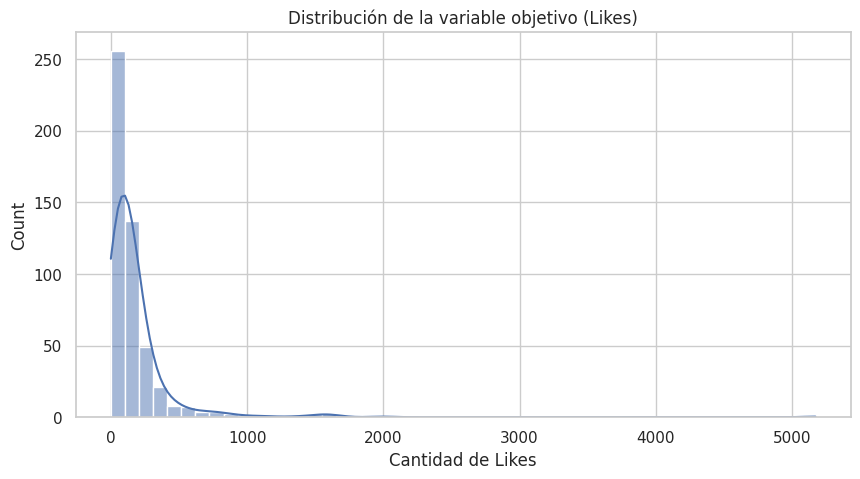

Estadísticas de Likes:
count     499.00
mean      177.95
std       323.40
min         0.00
25%        56.50
50%       101.00
75%       187.50
max      5172.00
Name: like, dtype: float64


In [14]:
# 2. Análisis del Target (Likes)
plt.figure(figsize=(10, 5))
sns.histplot(df['like'], bins=50, kde=True)
plt.title('Distribución de la variable objetivo (Likes)')
plt.xlabel('Cantidad de Likes')
plt.show()

print("Estadísticas de Likes:")
print(df['like'].describe().round(2))

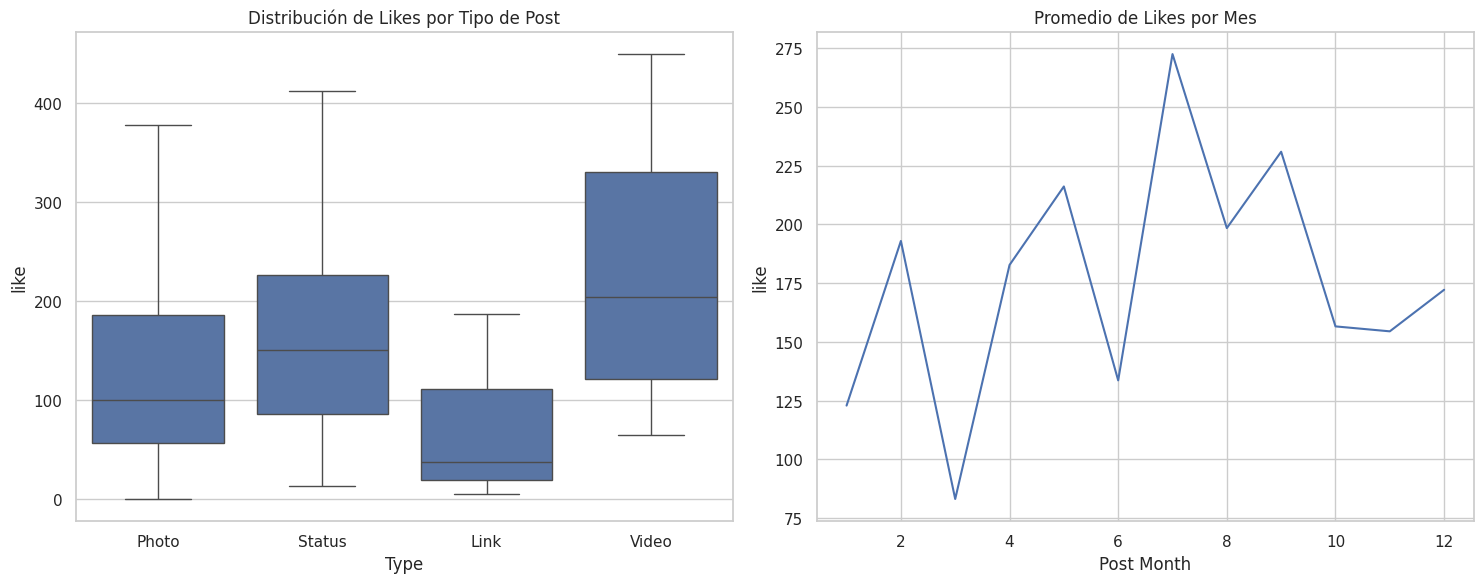

In [102]:
# 3. Relación Variables Categóricas vs Likes
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Tipo de Post
sns.boxplot(x='Type', y='like', data=df, ax=axes[0], showfliers=False)
axes[0].set_title('Distribución de Likes por Tipo de Post')

# Likes por Mes
sns.lineplot(x='Post Month', y='like', data=df, ax=axes[1], estimator='mean', errorbar = None)
axes[1].set_title('Promedio de Likes por Mes')

plt.tight_layout()
plt.show()


Número de outliers (IQR): 40
Rango normal: [-140.00, 384.00]
Número de outliers (Z-score > 3): 9


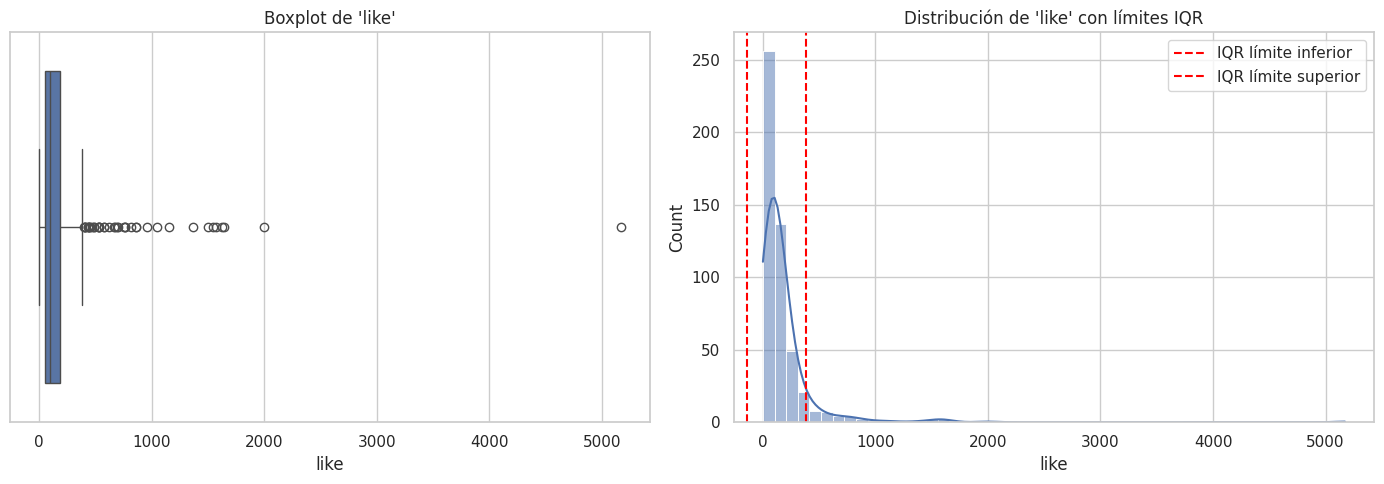

In [16]:
# --- Variable a analizar ---
likes = df['like']

# 1. Método IQR (Interquartile Range)
Q1 = likes.quantile(0.25)
Q3 = likes.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = likes[(likes < lower_bound) | (likes > upper_bound)]

print(f"Número de outliers (IQR): {len(outliers_iqr)}")
print(f"Rango normal: [{lower_bound:.2f}, {upper_bound:.2f}]")

# 2. Método Z-score
z_scores = (likes - likes.mean()) / likes.std()
outliers_z = likes[np.abs(z_scores) > 3]

print(f"Número de outliers (Z-score > 3): {len(outliers_z)}")

# 3. Visualización
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.boxplot(x=likes)
plt.title("Boxplot de 'like'")

plt.subplot(1,2,2)
sns.histplot(likes, bins=50, kde=True)
plt.axvline(lower_bound, color='red', linestyle='--', label='IQR límite inferior')
plt.axvline(upper_bound, color='red', linestyle='--', label='IQR límite superior')
plt.legend()
plt.title("Distribución de 'like' con límites IQR")

plt.tight_layout()
plt.show()


Publicaciones no virales (<1000 likes): 489
Publicaciones virales (>=1000 likes): 10

Estadísticas publicaciones NO virales:
count    489.000000
mean     143.490798
std      145.413840
min        0.000000
25%       56.000000
50%       99.000000
75%      181.000000
max      955.000000
Name: like, dtype: float64

Estadísticas publicaciones VIRALES:
count      10.000000
mean     1862.800000
std      1192.453009
min      1047.000000
25%      1405.250000
50%      1559.000000
75%      1634.750000
max      5172.000000
Name: like, dtype: float64


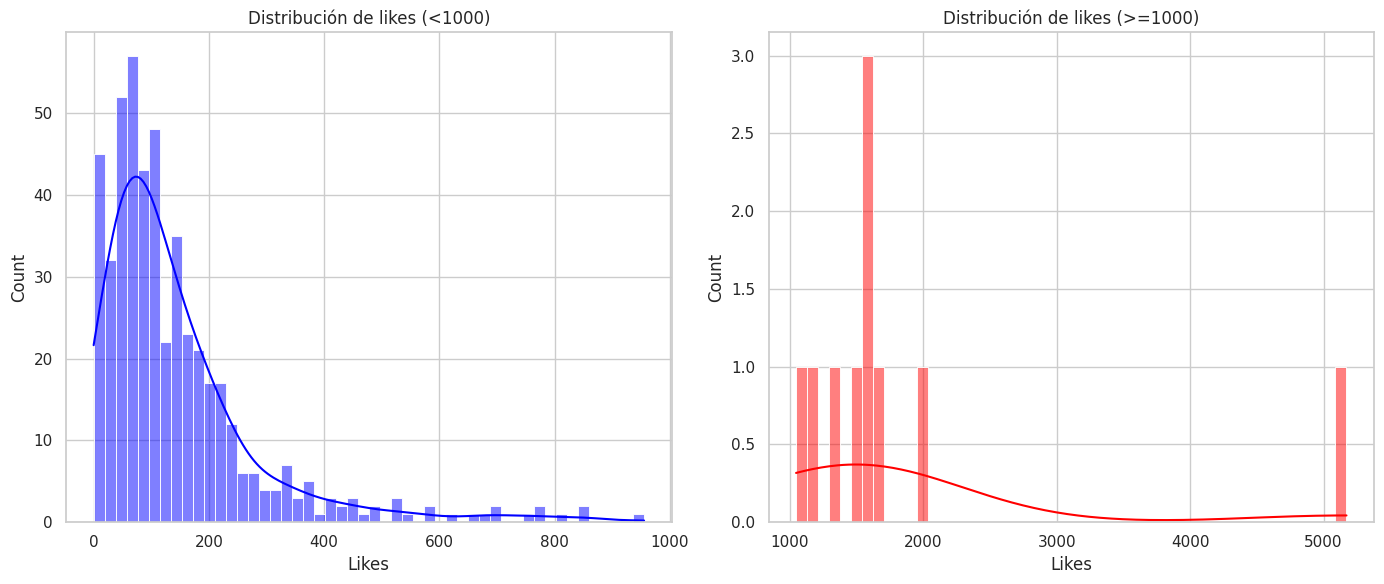

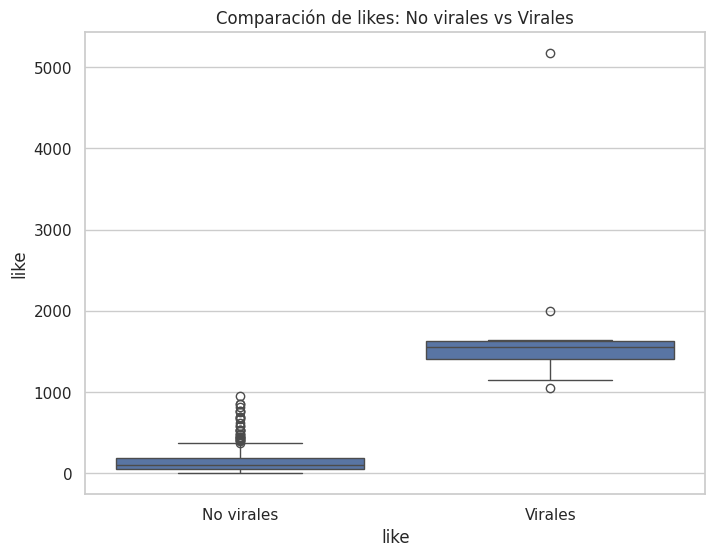

In [17]:
# --- Crear grupos ---
df_nonviral = df[df['like'] < 1000].copy()
df_viral = df[df['like'] >= 1000].copy()

print(f"Publicaciones no virales (<1000 likes): {df_nonviral.shape[0]}")
print(f"Publicaciones virales (>=1000 likes): {df_viral.shape[0]}")

# --- Estadísticas descriptivas ---
stats_nonviral = df_nonviral['like'].describe()
stats_viral = df_viral['like'].describe()

print("\nEstadísticas publicaciones NO virales:")
print(stats_nonviral)

print("\nEstadísticas publicaciones VIRALES:")
print(stats_viral)

# --- Visualización comparativa ---
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.histplot(df_nonviral['like'], bins=50, kde=True, color='blue')
plt.title("Distribución de likes (<1000)")
plt.xlabel("Likes")

plt.subplot(1,2,2)
sns.histplot(df_viral['like'], bins=50, kde=True, color='red')
plt.title("Distribución de likes (>=1000)")
plt.xlabel("Likes")

plt.tight_layout()
plt.show()

# --- Boxplot comparativo ---
plt.figure(figsize=(8,6))
sns.boxplot(x=pd.cut(df['like'], bins=[0,1000,df['like'].max()],
                    labels=['No virales','Virales']),
            y=df['like'])
plt.title("Comparación de likes: No virales vs Virales")
plt.show()


Estadísticas de 'like' por grupo (0 = no viral, 1 = viral):
            count         mean          std     min      25%     50%      75%  \
viral_flag                                                                      
0           489.0   143.490798   145.413840     0.0    56.00    99.0   181.00   
1            10.0  1862.800000  1192.453009  1047.0  1405.25  1559.0  1634.75   

               max  
viral_flag          
0            955.0  
1           5172.0  


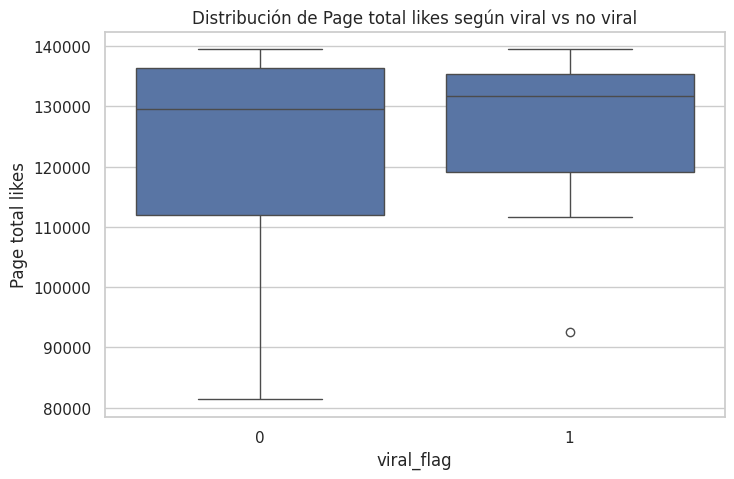

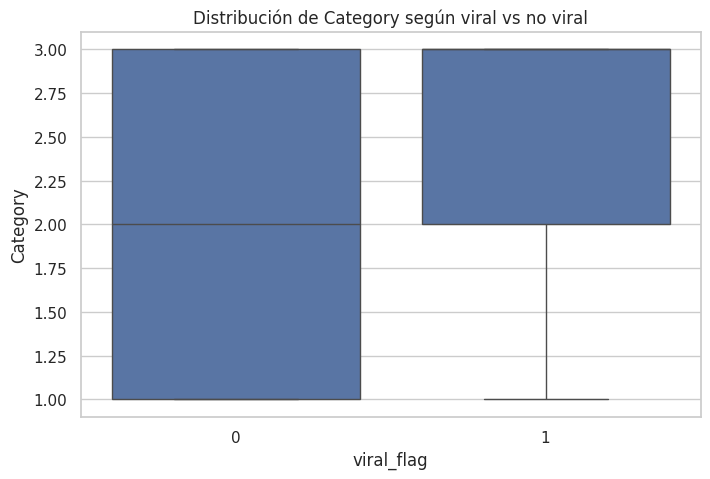

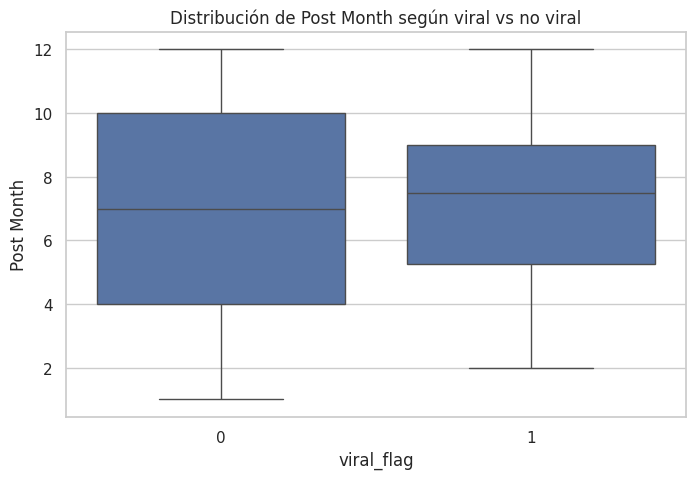

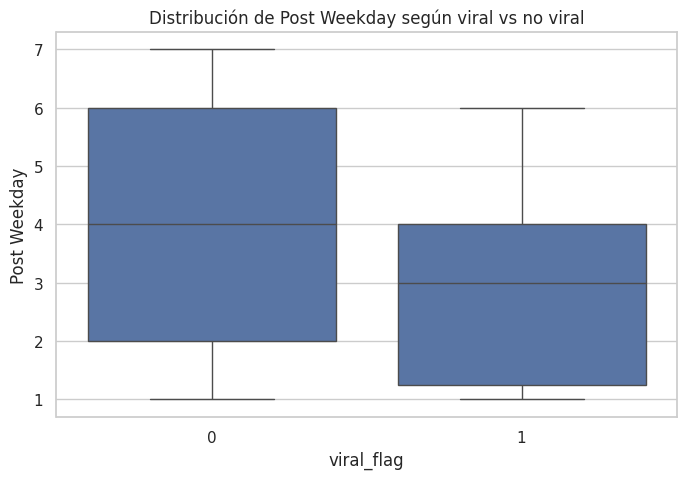

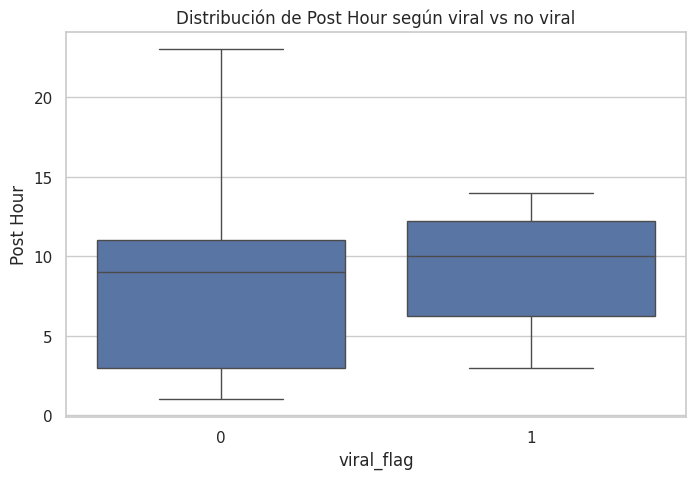

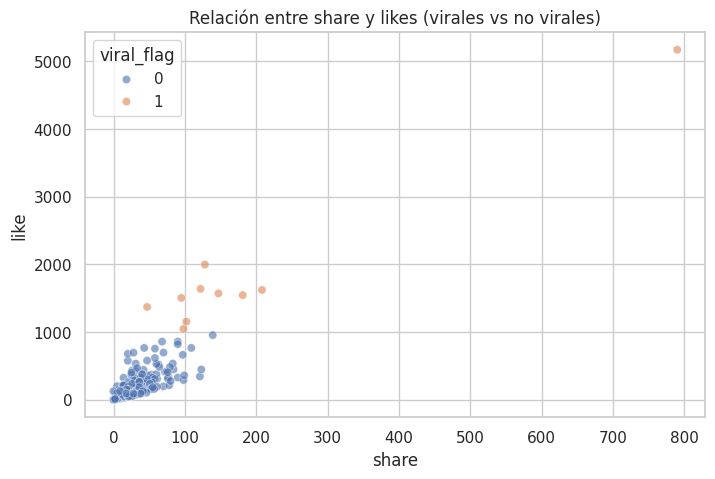

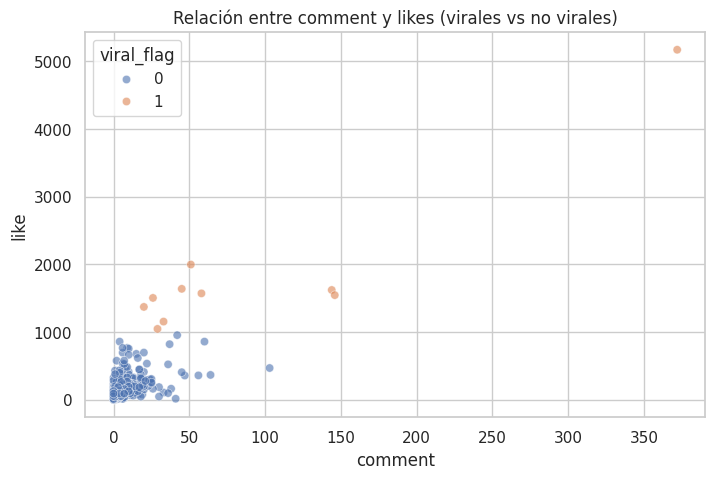

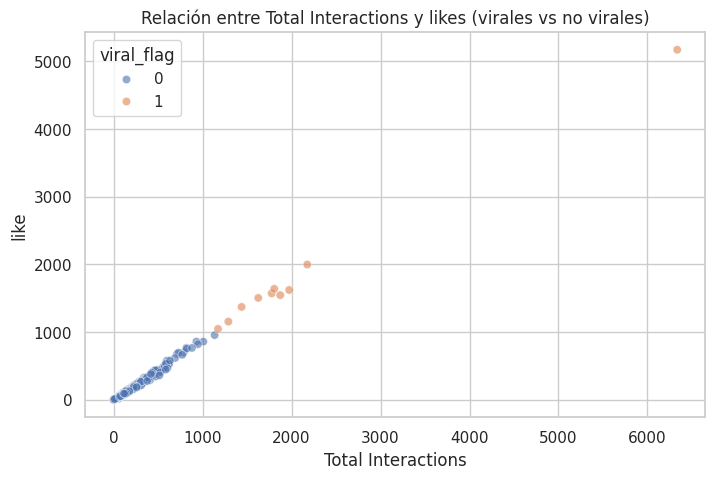

In [18]:
# --- Crear copia del DataFrame ---
df_copy = df.copy()

# --- Crear variable binaria: viral vs no viral ---
df_copy['viral_flag'] = (df_copy['like'] >= 1000).astype(int)

# --- Estadísticas descriptivas por grupo ---
group_stats = df_copy.groupby('viral_flag').describe()['like']
print("Estadísticas de 'like' por grupo (0 = no viral, 1 = viral):")
print(group_stats)

# --- Comparar otras variables numéricas ---
numeric_cols = df_copy.select_dtypes(include=['int64','float64']).columns.drop('like')

for col in numeric_cols[:5]:  # limitar a 5 para no saturar
    plt.figure(figsize=(8,5))
    sns.boxplot(x='viral_flag', y=col, data=df_copy)
    plt.title(f"Distribución de {col} según viral vs no viral")
    plt.show()

# --- Scatterplot ejemplo con shares y comments ---
for col in ['share','comment','Total Interactions']:
    if col in df_copy.columns:
        plt.figure(figsize=(8,5))
        sns.scatterplot(x=col, y='like', hue='viral_flag', data=df_copy, alpha=0.6)
        plt.title(f"Relación entre {col} y likes (virales vs no virales)")
        plt.show()


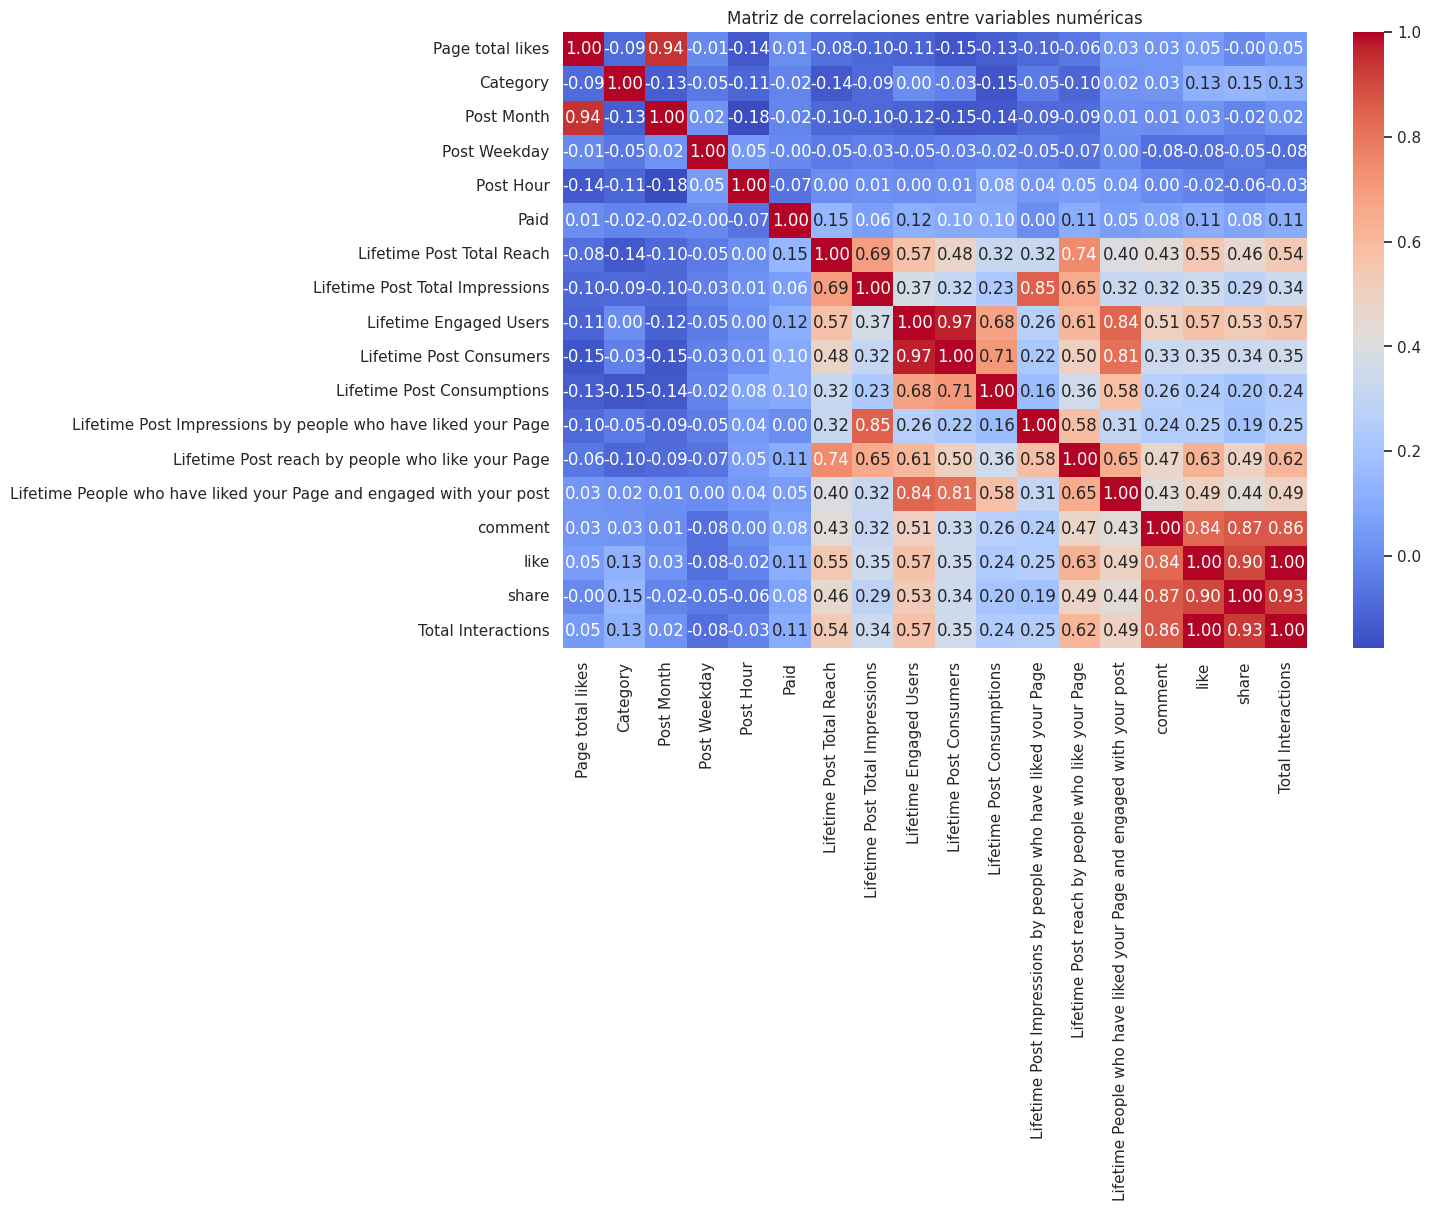

In [19]:
# --- Matriz de correlaciones ---
corr_matrix = df.corr(numeric_only=True)  # solo columnas numéricas

# --- Heatmap ---
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de correlaciones entre variables numéricas")
plt.show()


## 3. Preprocess

### 3.1 Nulos

##### 3.1.1 NA en Target

In [26]:
# No nos sirven registros sin target
target_na = df['like'].isna().sum()
print(f"\n🎯 Registros con 'like' nulo: {target_na}")
df_clean = df.dropna(subset=['like']).copy()

# chequeo rápido
print(df_clean.isna().sum())



🎯 Registros con 'like' nulo: 1
Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   1
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach

##### 3.1.2 NA en Paid

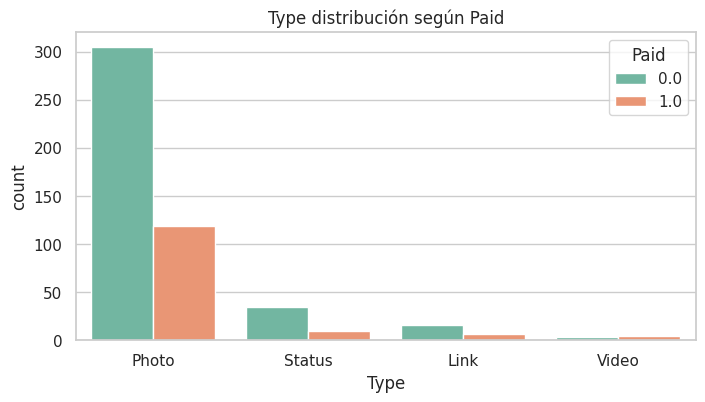

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   0
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

In [27]:
# --- Análisis de registros nulos en features nulos ---

# Nulo en 'Paid'

num_cols = df_clean.select_dtypes(include=['int64','float64']).columns

# for col in num_cols:
#     plt.figure(figsize=(8,4))
#     sns.boxplot(x='Paid', y=col, data=df_clean, palette='Set2')
#     sns.stripplot(x='Paid', y=col, data=df_clean[df_clean['Paid'].isna()],
#                   color='red', marker='x', size=8, label='NA')
#     plt.title(f"{col} vs Paid (0/1/NA)")
#     plt.legend()
#     plt.show()

# # Variables categóricas
# cat_cols = df_clean.select_dtypes(include=['object']).columns

# for col in cat_cols:
#     plt.figure(figsize=(8,4))
#     sns.countplot(x=col, hue='Paid', data=df_clean, palette='Set2')
#     plt.title(f"{col} distribución según Paid")
#     plt.show()



plt.figure(figsize=(8,4))
sns.countplot(x='Type', hue='Paid', data=df_clean, palette='Set2')
plt.title(f"Type distribución según Paid")
plt.show()

# Dado que su type es "Photo", podemos inferir que es un post no pago

df_clean.loc[df_clean['Type'] == 'Photo', 'Paid'] = df_clean.loc[df_clean['Type'] == 'Photo', 'Paid'].fillna(0)

print(df_clean.isna().sum())



##### 3.1.3 NAs en share

In [28]:
# Chequeo de q para todos los registros sin NA se cumple que Total Interactions = comment + like + share

df_no_na = df_clean.dropna(subset=["Total Interactions", "comment", "like", "share"]).copy()

df_no_na["check_interactions"] = (
    df_no_na["Total Interactions"] == df_no_na["comment"] + df_no_na["like"] + df_no_na["share"]
)


# Verificamos si todos cumplen
all_good = df_no_na["check_interactions"].all()

print("¿Todos los registros cumplen la condición?", all_good)


¿Todos los registros cumplen la condición? True


In [29]:
# Imputo share

# Imputar valores faltantes en 'share' usando la relación validada
df_clean.loc[df_clean["share"].isna(), "share"] = (
    df_clean["Total Interactions"] - df_clean["comment"] - df_clean["like"]
)

# Chequeo rápido: ya no debería haber NAs en 'share'
print(df_clean["share"].isna().sum())


0


In [30]:
# Chequeo rápido: ya no debería haber NAs en 'share'
print(df_clean.isna().sum())

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   0
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

### 3.2 Pipeline de Scaler y Dummies

In [31]:
# --- Pipeline de Preprocesamiento
# 1. Definir X e y
y = df_clean['like']
X = df_clean.drop(columns=['like'])

# 2. Función para crear PostHourBin
def bin_post_hour(X):
    X = X.copy()
    bins = [0, 6, 12, 18, 24]
    labels = ['Madrugada', 'Mañana', 'Tarde', 'Noche']
    X['PostHourBin'] = pd.cut(X['Post Hour'], bins=bins, labels=labels, right=False)
    return X

binning_transformer = FunctionTransformer(bin_post_hour, validate=False)

# 3. Definir columnas
numeric_as_category = ['Category']
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_features = [col for col in numeric_features if col not in numeric_as_category]
categorical_features = list(X.select_dtypes(include=['object']).columns) + numeric_as_category

# 4. Transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

weekday_hour_interactions = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

# 5. Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        # ('weekday_hour', weekday_hour_interactions, ['Post Weekday','PostHourBin'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)


# Aplicar binning + preprocessor directamente
X_preprocessed = Pipeline(steps=[
    # ('binning', binning_transformer),
    ('preprocessor', preprocessor)
]).fit_transform(X)

# Convertir a DataFrame con nombres de columnas
feature_names = preprocessor.get_feature_names_out()
X_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names, index=X.index)

print(X_preprocessed.shape)
print(X_preprocessed.head())


(499, 23)
   Page total likes  Post Month  Post Weekday  Post Hour  Paid  \
0          0.408866    0.833333          0.00     -0.750   0.0   
1          0.408866    0.833333         -0.25      0.125   0.0   
2          0.408866    0.833333         -0.25     -0.750   0.0   
3          0.408866    0.833333         -0.50      0.125   1.0   
4          0.408866    0.833333         -0.50     -0.750   0.0   

   Lifetime Post Total Reach  Lifetime Post Total Impressions  \
0                  -0.256540                        -0.241094   
1                   0.525046                         0.605767   
2                  -0.290915                        -0.284631   
3                   4.547353                         4.785738   
4                   0.198945                         0.274505   

   Lifetime Engaged Users  Lifetime Post Consumers  \
0               -0.672673                -0.712570   
1                1.247748                 1.292234   
2               -0.674174               

## 4. Modelos

### 4.1 Modelos Incluyendo todos los features


#### 4.1.1 RF - Todos los casos

In [78]:
# 1. Selección de Features

features_to_drop = ['Total Interactions']
X = X_preprocessed.drop(columns=features_to_drop)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 22), Test shape: (100, 22)


In [79]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline con el modelo
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__bootstrap': True, 'regressor__max_depth': 15, 'regressor__max_features': 0.6965379620637286, 'regressor__max_samples': 1.0, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 78})


In [80]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 71.85
RMSE (Raíz Error Cuadrático): 178.37
R2 Score: 0.4441


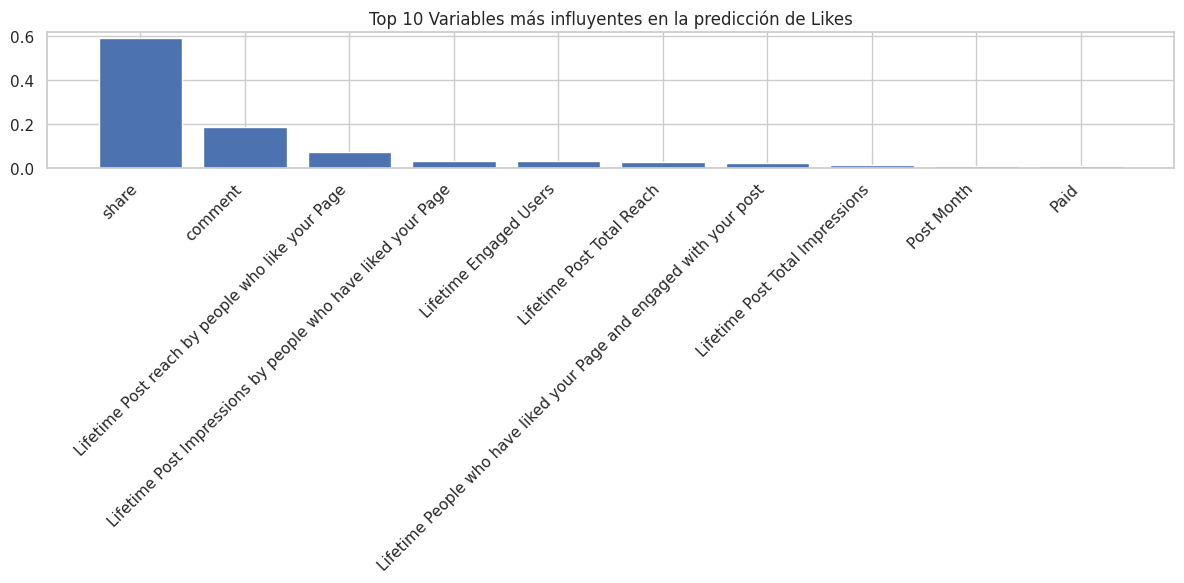

In [81]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']  # si usaste pipeline
# Si no tenés pipeline, simplemente: rf_model = best_model

# Importancias
importances = rf_model.feature_importances_

# Nombres de features (usa X_train.columns si no tenés preprocesador)
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 4.1.2 RF - Excluyo casos virales en train


In [82]:
# Split primero SIN filtrar
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, df_clean['like'], test_size=0.2, random_state=42
)

# Filtrar solo en train
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train].copy()

# Opcional: drop de features
features_to_drop = ['Total Interactions']
X_train = X_train.drop(columns=features_to_drop, errors='ignore')
X_test = X_test.drop(columns=features_to_drop, errors='ignore')

# --- Logs de trazabilidad ---
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos en train: {(~mask_train).sum()}")
print(f"Casos virales presentes en test: {(y_test >= 1000).sum()}")
print(f"Casos no virales en test: {(y_test < 1000).sum()}")


Train shape: (392, 22), Test shape: (100, 22)
Casos virales excluidos en train: 7
Casos virales presentes en test: 3
Casos no virales en test: 97


In [83]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline con el modelo
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__bootstrap': True, 'regressor__max_depth': 8, 'regressor__max_features': 1.0, 'regressor__max_samples': 1.0, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 20})


In [84]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 63.53
RMSE (Raíz Error Cuadrático): 149.81
R2 Score: 0.6079


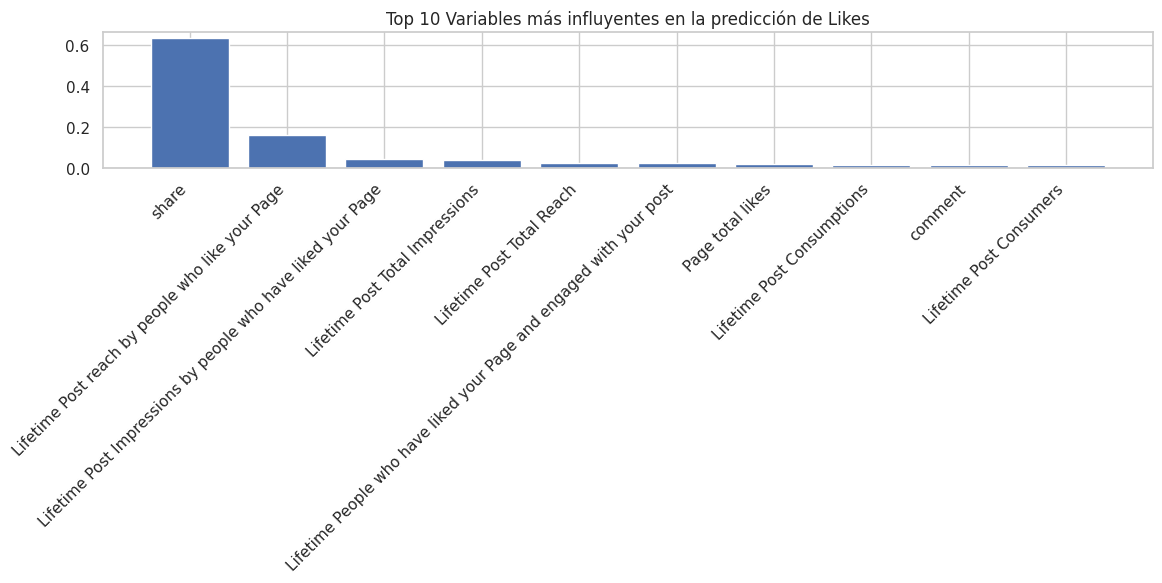

In [86]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']  # si usaste pipeline
# Si no tenés pipeline, simplemente: rf_model = best_model

# Importancias
importances = rf_model.feature_importances_

# Nombres de features (usa X_train.columns si no tenés preprocesador)
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 4.1.3 KNN - Todos los casos

In [87]:
# 1. Selección de Features

features_to_keep = ['share','comment']
X = X_preprocessed[features_to_keep]
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 2), Test shape: (100, 2)


In [88]:
# KNN

pipe_knn = Pipeline(steps=[
    ('regressor', KNeighborsRegressor())
])


# 4. Optimización Bayesiana para KNN
# Espacio de hiperparámetros para KNN
param_space_knn = {
    'regressor__n_neighbors': Integer(2, 30),          # número de vecinos
    'regressor__weights': Categorical(['distance']),  # ponderación
    'regressor__p': Integer(1, 2)                      # métrica: 1=Manhattan, 2=Euclídea
}

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Optimización bayesiana
opt_knn = BayesSearchCV(
    estimator=pipe_knn,
    search_spaces=param_space_knn,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Entrenamos la optimización
opt_knn.fit(X_train, y_train)

print("Mejores hiperparámetros KNN:", opt_knn.best_params_)


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.int64(2), np.str_('distance')] before, using random point [np.int64(26), np.int64(1), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.int64(2), np.str_('distance')] before, using random point [np.int64(7), np.int64(1), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.int64(2), np.str_('distance')] before, using random point [np.int64(13), np.int64(2), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.int64(2), np.str_('distance')] before, using random point [np.int64(13),

Mejores hiperparámetros KNN: OrderedDict({'regressor__n_neighbors': 4, 'regressor__p': 1, 'regressor__weights': 'distance'})


In [89]:
# Mejor modelo optimizado
best_knn = opt_knn.best_estimator_

# Predicciones
y_pred_knn = best_knn.predict(X_test)

# Métricas
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"--- Resultados del Mejor KNN Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_knn:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_knn:.2f}")
print(f"R2 Score: {r2_knn:.4f}")


--- Resultados del Mejor KNN Optimizado ---
MAE (Error Absoluto Medio): 74.87
RMSE (Raíz Error Cuadrático): 175.69
R2 Score: 0.4607


#### 4.1.2 KNN - Excluyo casos virales en train

In [90]:
# --- Selección de Features ---
features_to_keep = ['share','comment']
X = X_preprocessed[features_to_keep]
y = df_clean['like']

# --- Split 80-20 (sin filtrar todavía) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Filtro solo en TRAIN ---
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train]

print(f"Train shape (filtrado): {X_train.shape}, Test shape (sin filtrar): {X_test.shape}")


Train shape (filtrado): (392, 2), Test shape (sin filtrar): (100, 2)


In [91]:
# KNN

pipe_knn = Pipeline(steps=[
    ('regressor', KNeighborsRegressor())
])


# 4. Optimización Bayesiana para KNN
# Espacio de hiperparámetros para KNN
param_space_knn = {
    'regressor__n_neighbors': Integer(2, 30),          # número de vecinos
    'regressor__weights': Categorical(['distance']),  # ponderación
    'regressor__p': Integer(1, 2)                      # métrica: 1=Manhattan, 2=Euclídea
}

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Optimización bayesiana
opt_knn = BayesSearchCV(
    estimator=pipe_knn,
    search_spaces=param_space_knn,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Entrenamos la optimización
opt_knn.fit(X_train, y_train)

print("Mejores hiperparámetros KNN:", opt_knn.best_params_)


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(8), np.int64(2), np.str_('distance')] before, using random point [np.int64(24), np.int64(2), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(8), np.int64(2), np.str_('distance')] before, using random point [np.int64(9), np.int64(2), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(8), np.int64(2), np.str_('distance')] before, using random point [np.int64(28), np.int64(2), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(8), np.int64(2), np.str_('distance')] before, using random point [np.int64(11),

Mejores hiperparámetros KNN: OrderedDict({'regressor__n_neighbors': 8, 'regressor__p': 2, 'regressor__weights': 'distance'})


In [92]:
# Mejor modelo optimizado
best_knn = opt_knn.best_estimator_

# Predicciones
y_pred_knn = best_knn.predict(X_test)

# Métricas
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"--- Resultados del Mejor KNN Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_knn:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_knn:.2f}")
print(f"R2 Score: {r2_knn:.4f}")


--- Resultados del Mejor KNN Optimizado ---
MAE (Error Absoluto Medio): 79.00
RMSE (Raíz Error Cuadrático): 186.72
R2 Score: 0.3909


## 4.2 Modelos Excluyendo features con data leakege


#### 4.2.1 Linear Regression (Ridge) - Todos los casos

In [51]:
# 1. Selección de Features

leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment","share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 12), Test shape: (100, 12)


In [52]:
# Regresión Lineal con Ridge
pipe = Pipeline(steps=[
    ('regressor', Ridge())
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Espacio de hiperparámetros
param_space = {
    'regressor__alpha': Real(1e-3, 200, prior='log-uniform')  # fuerza de regularización
}

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'   # en regresión lineal suele ser más interpretativo
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__alpha': 76.1387526709249})


In [53]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 139.45
RMSE (Raíz Error Cuadrático): 232.49
R2 Score: 0.0557


In [54]:
# Mejor modelo lineal
lr = best_model.named_steps['regressor']  # Ridge / LinearRegression / Lasso

coef = lr.coef_
intercept = lr.intercept_

# Usar directamente las columnas de X_preprocessed
feature_names = X_train.columns  # si hiciste split sobre X_preprocessed

import pandas as pd
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
}).sort_values(by='coefficient', key=abs, ascending=False)

print(coef_df.head(20))  # top 20 más influyentes


             feature  coefficient
9         Category_1   -43.392757
4               Paid    40.534493
2       Post Weekday   -27.791796
11        Category_3    23.581692
10        Category_2    19.811065
0   Page total likes    17.329677
5          Type_Link   -11.659216
6         Type_Photo     9.208724
8         Type_Video     4.828544
7        Type_Status    -2.378052
3          Post Hour     2.026777
1         Post Month     0.768399


#### 4.2.2 Linear Regression (ridge) - Excluyo casos virales en train

In [57]:
# 1. Selección de Features (leakage eliminados en ambos)
leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment", "share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# 2. Split 80-20 (primero separamos)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Excluir casos virales SOLO en train
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train].copy()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos SOLO en train: {(~mask_train).sum()}")
print(f"Casos virales presentes en test: {(y_test >= 1000).sum()}")


Train shape: (392, 12), Test shape: (100, 12)
Casos virales excluidos SOLO en train: 7
Casos virales presentes en test: 3


In [58]:
# Regresión Lineal con Ridge
pipe = Pipeline(steps=[
    ('regressor', Ridge())
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Espacio de hiperparámetros
param_space = {
    'regressor__alpha': Real(1e-3, 200, prior='log-uniform')  # fuerza de regularización
}

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'   # en regresión lineal suele ser más interpretativo
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__alpha': 11.045332139595775})


In [59]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 127.25
RMSE (Raíz Error Cuadrático): 235.41
R2 Score: 0.0318


In [60]:
# Mejor modelo lineal
lr = best_model.named_steps['regressor']  # Ridge / LinearRegression / Lasso

coef = lr.coef_
intercept = lr.intercept_

# Usar directamente las columnas de X_preprocessed
feature_names = X_train.columns  # si hiciste split sobre X_preprocessed

import pandas as pd
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
}).sort_values(by='coefficient', key=abs, ascending=False)

print(coef_df.head(20))  # top 20 más influyentes


             feature  coefficient
5          Type_Link   -39.139836
8         Type_Video    30.821320
11        Category_3    28.282688
9         Category_1   -27.366910
4               Paid    21.410931
3          Post Hour   -20.234646
7        Type_Status    18.277503
0   Page total likes    15.357244
6         Type_Photo    -9.958987
1         Post Month     3.870192
2       Post Weekday    -1.553318
10        Category_2    -0.915778


#### 4.2.3 RF - Todos los casos

In [61]:
# 1. Selección de Features

leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment", "share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 12), Test shape: (100, 12)


In [62]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline SOLO con el modelo (sin binning, sin preprocessor, sin interaction_transformer)
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'  # podés cambiar a 'r2' si preferís
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__bootstrap': True, 'regressor__max_depth': 15, 'regressor__max_features': 0.8834892067157285, 'regressor__max_samples': 0.5943976103646323, 'regressor__min_samples_leaf': 7, 'regressor__min_samples_split': 20, 'regressor__n_estimators': 142})


In [63]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 142.45
RMSE (Raíz Error Cuadrático): 237.73
R2 Score: 0.0126


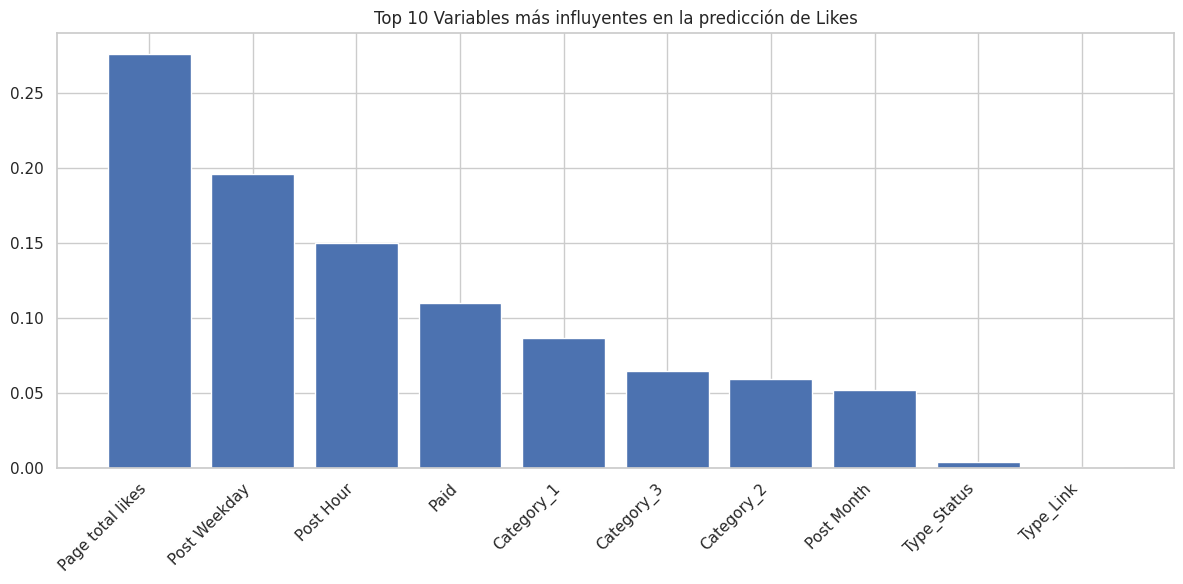

In [64]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']  # si usaste pipeline
# Si no tenés pipeline, simplemente: rf_model = best_model

# Importancias
importances = rf_model.feature_importances_

# Nombres de features (usa X_train.columns si no tenés preprocesador)
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 4.2.4 RF - Excluyendo casos virales en train

In [65]:
# 1. Selección de Features (leakage eliminados en ambos)
leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment", "share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# 2. Split 80-20 (primero separamos)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Excluir casos virales SOLO en train
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train].copy()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos SOLO en train: {(~mask_train).sum()}")
print(f"Casos virales presentes en test: {(y_test >= 1000).sum()}")


Train shape: (392, 12), Test shape: (100, 12)
Casos virales excluidos SOLO en train: 7
Casos virales presentes en test: 3


In [66]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline SOLO con el modelo (sin binning, sin preprocessor, sin interaction_transformer)
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'  # podés cambiar a 'r2' si preferís
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__bootstrap': True, 'regressor__max_depth': 12, 'regressor__max_features': 0.35259274989425227, 'regressor__max_samples': 0.9706574761220621, 'regressor__min_samples_leaf': 7, 'regressor__min_samples_split': 17, 'regressor__n_estimators': 88})


In [67]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 125.10
RMSE (Raíz Error Cuadrático): 234.35
R2 Score: 0.0405


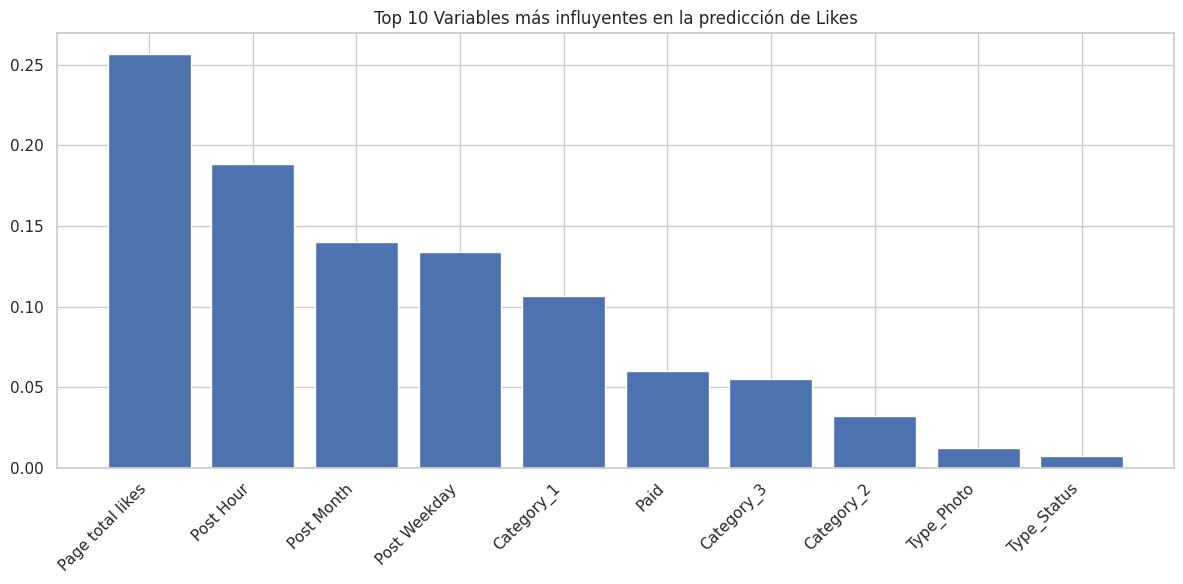

In [68]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']  # si usaste pipeline
# Si no tenés pipeline, simplemente: rf_model = best_model

# Importancias
importances = rf_model.feature_importances_

# Nombres de features (usa X_train.columns si no tenés preprocesador)
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 4.2.5 XGBoost - Todos los casos

In [69]:
# 1. Selección de Features

leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment","share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 12), Test shape: (100, 12)


In [70]:
# Espacio de hiperparámetros para XGBoost
param_space = {
    'regressor__n_estimators': Integer(50, 300),
    'regressor__max_depth': Integer(2, 15),
    'regressor__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'regressor__subsample': Real(0.5, 1.0),
    'regressor__colsample_bytree': Real(0.5, 1.0),
}

# Pipeline SOLO con XGBoost (sin binning, sin preprocessor, sin interaction_transformer)
pipe = Pipeline(steps=[
    ('regressor', XGBRegressor(
        objective='reg:squarederror',   # regresión clásica
        random_state=42,
        n_jobs=-1,
        tree_method='hist'              # más rápido en datasets medianos
    ))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'   # podés cambiar a 'neg_mean_squared_error' si preferís
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.0033628364345045063, 'regressor__max_depth': 500, 'regressor__n_estimators': 128, 'regressor__subsample': 0.5})


In [71]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 142.70
RMSE (Raíz Error Cuadrático): 236.48
R2 Score: 0.0230


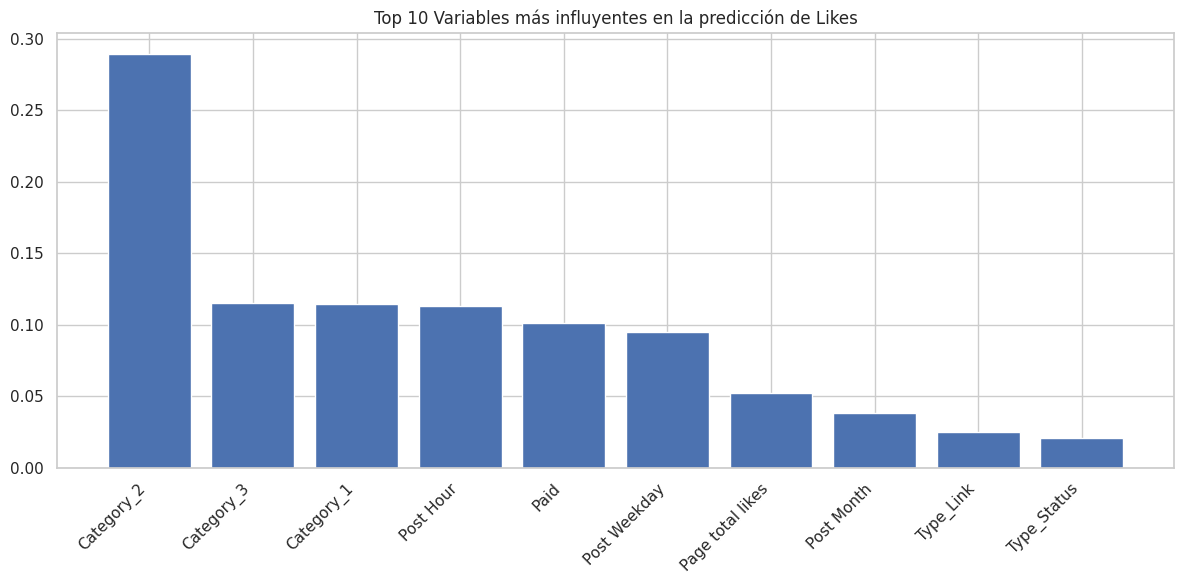

In [72]:
# Paso 1: nombres de features desde el train limpio
feature_names = X_train.columns

# Paso 2: importancias
importances = rf.feature_importances_

# Paso 3: ordenar y graficar
indices = np.argsort(importances)[::-1]
top_n = min(10, len(feature_names))

plt.figure(figsize=(12, 6))
plt.title("Top Variables más influyentes en la predicción de Likes")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### 4.2.3 XGBoost - Excluyendo casos virales en train

In [73]:
# 1. Selección de Features (leakage eliminados en ambos)
leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment", "share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# 2. Split 80-20 (primero separamos)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Excluir casos virales SOLO en train
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train].copy()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos SOLO en train: {(~mask_train).sum()}")
print(f"Casos virales presentes en test: {(y_test >= 1000).sum()}")


Train shape: (392, 12), Test shape: (100, 12)
Casos virales excluidos SOLO en train: 7
Casos virales presentes en test: 3


In [74]:
# Espacio de hiperparámetros para XGBoost
param_space = {
    'regressor__n_estimators': Integer(50, 1000),        # número de árboles
    'regressor__max_depth': Integer(5, 500),             # profundidad máxima
    'regressor__learning_rate': Real(0.001, 0.15, prior='log-uniform'),  # tasa de aprendizaje
    'regressor__subsample': Real(0.5, 1.0),              # fracción de muestras por árbol
    'regressor__colsample_bytree': Real(0.5, 1.0),       # fracción de features por árbol
}

# Pipeline SOLO con XGBoost (sin binning, sin preprocessor, sin interaction_transformer)
pipe = Pipeline(steps=[
    ('regressor', XGBRegressor(
        objective='reg:squarederror',   # regresión clásica
        random_state=42,
        n_jobs=-1,
        tree_method='hist'              # más rápido en datasets medianos
    ))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'   # podés cambiar a 'neg_mean_squared_error' si preferís
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict({'regressor__colsample_bytree': 0.5362758062487112, 'regressor__learning_rate': 0.0014749889342692618, 'regressor__max_depth': 500, 'regressor__n_estimators': 1000, 'regressor__subsample': 0.5})


In [75]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 127.30
RMSE (Raíz Error Cuadrático): 236.41
R2 Score: 0.0235


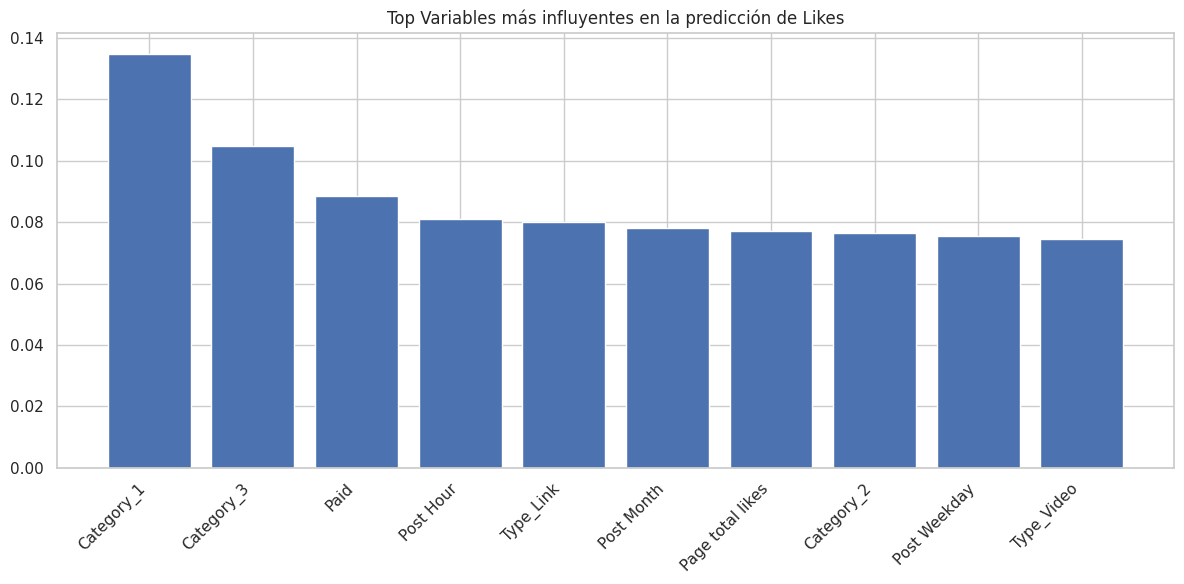

In [77]:
# Paso 1: nombres de features desde el train limpio
feature_names = X_train.columns

# Paso 2: importancias
importances = rf.feature_importances_

# Paso 3: ordenar y graficar
indices = np.argsort(importances)[::-1]
top_n = min(10, len(feature_names))

plt.figure(figsize=(12, 6))
plt.title("Top Variables más influyentes en la predicción de Likes")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()
